In [1]:
import numpy as np

def getTrainingData():
    return np.genfromtxt("training.csv", delimiter=",", dtype=np.int)

def getValidationData():
    return np.genfromtxt("validation.csv", delimiter=",", dtype=np.int)

def getUsefulStats(training):
    movies = [x[0] for x in training]
    u_movies = np.unique(movies).tolist()

    users = [x[1] for x in training]
    u_users = np.unique(users).tolist()

    return {
        "movies": movies, # movie IDs
        "u_movies": u_movies, # unique movie IDs
        "n_movies": len(u_movies), # number of unique movies

        "users": users, # user IDs
        "u_users": u_users, # unique user IDs
        "n_users": len(u_users), # number of unique users

        "ratings": [x[2] for x in training], # ratings
        "n_ratings": len(training) # number of ratings
    }

def rmse(r, r_hat):
    r = np.array(r)
    r_hat = np.array(r_hat)
    return np.linalg.norm(r - r_hat) / np.sqrt(len(r))

def getRatingsForUser(user, training):
    # user is a user ID
    # training is the training set
    # ret is a matrix, each row is [m, r] where
    #   m is the movie ID
    #   r is the rating, 1, 2, 3, 4 or 5
    return np.array([[x[0], x[2]] for x in training if x[1] == user])

In [2]:
import numpy as np
import scipy.special

# set highest rating
K = 5

def softmax(x):
    # Numerically stable softmax function
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# returns an array with 3 columns in the order of index, movie no. and number of ratings
def ratingsPerMovie(training):
    movies = [x[0] for x in training]
    u_movies = np.unique(movies).tolist()
    return np.array([[i, movie, len([x for x in training if x[0] == movie])] for i, movie in enumerate(u_movies)])

def getV(ratingsForUser):
    #   ratingsForUser is obtained from the ratings for user library
    #   it takes in a matrix where each row is [m, r], m being the movie ID and r being the rating
    #   you should return a binary matrix ret of size m x K, where m is the number of movies
    #   that the user has seen. ret[i][k] = 1 if the user
    #   has rated movie ratingsForUser[i, 0] with k stars
    #   otherwise it is 0
    ret = np.zeros((len(ratingsForUser), K))
    for i in range(len(ratingsForUser)):
        ret[i, ratingsForUser[i, 1]-1] = 1.0
    return ret

def getInitialWeights(m, F, K):
    # m is the number of visible units
    # F is the number of hidden units
    # K is the highest rating (fixed to 5 here)
    return np.random.normal(0, 0.1, (m, F, K))

def getB(F):
    #generates a vector B of length F
    return np.zeros(F)

def getA(K, training):
    #generates a bias matrix A of size m x K, where m is the number of movies and K is the value of ratings
    m = trStats['n_movies']
    A = np.zeros((m,K))
    for i in range(m):
        ratings = [x[2] for x in training if x[0] == i]
        for j in range(K):
            p = ratings.count(j+1)/trStats['n_users']
            if p > 0:
                A[i,j] = np.log(p/(1-p))
    return A

def sig(x):
    # x is a real vector of size n
    # ret should be a vector of size n where ret_i = sigmoid(x_i)
    return scipy.special.expit(x)

def visibleToHiddenVec(v, w, b):
    # v is a matrix of size m x 5. Each row is a binary vector representing a rating
    #    OR a probability distribution over the rating
    # w is a list of matrices of size m x F x 5
    # h should be a vector of size F
    # b should be a vector of size F
    F = len(w[0])
    h = np.zeros(F)
    for i in range(F):
        for j in range(len(v)):
            h[i] += np.dot(v[j],w[j,i,:])
    h = sig(b + h)
    return h

def hiddenToVisible(h, w, a):
    # h is a binary vector of size F
    # w is an array of size m x F x 5
    # ret should be a matrix of size m x 5, where m
    #   is the number of movies the user has seen.
    #   Remember that we do not reconstruct movies that the user
    #   has not rated! (where reconstructing means getting a distribution
    #   over possible ratings).
    #   We only do so when we predict the rating a user would have given to a movie.
    # a is a matrix of size m x K, where entry ij represents bias of movie i and rating j
    v = np.matrix(np.zeros((len(w),K)))
    for i in range(len(w)):
        for k in range(K):
            v[i,k] += a[i,k] + np.dot(h,w[i,:,k]) 
        total = np.sum(v[i])
        if total > 0:
            v[i,:] = v[i,:]/total
#     v = sig(v)
    return v

def probProduct(v, p):
    # v is a matrix of size m x 5
    # p is a vector of size F, activation of the hidden units
    # returns the gradient for visible input v and hidden activations p
    ret = np.zeros((v.shape[0], len(p), v.shape[1]))
    for i in range(v.shape[0]):
        for j in range(len(p)):
            for k in range(v.shape[1]):
                ret[i, j, k] = v[i, k] * p[j]
    return ret

def sample(p):
    # p is a vector of real numbers between 0 and 1
    # ret is a vector of same size as p, where ret_i = Ber(p_i)
    # In other word we sample from a Bernouilli distribution with
    # parameter p_i to obtain ret_i
    samples = np.random.random(len(p))
    return np.array(samples <= p, dtype=int)

def getPredictedDistribution(v, w, wq, aq, b):
    ### TO IMPLEMENT ###
    # This function returns a distribution over the ratings for movie q, if user data is v
    # v is the dataset of the user we are predicting the movie for
    #   It is a m x 5 matrix, where m is the number of movies in the
    #   dataset of this user.
    # w is the weights array for the current user, of size m x F x 5
    # wq is the weight matrix of size F x 5 for movie q
    #   If W is the whole weights array, then wq = W[q, :, :]
    # You will need to perform the same steps done in the learning/unlearning:
    #   - Propagate the user input to the hidden units
    #   - Sample the state of the hidden units
    #   - Backpropagate these hidden states to obtain
    #       the distribution over the movie whose associated weights are wq
    # ret is a vector of size 5
    h = visibleToHiddenVec(v, w, b)
    h_sample = sample(h)
    ret = [0,0,0,0,0]
    for i in range(K):
        ret[i] += aq[i] + np.dot(h_sample,wq[:,i])
    if sum(ret)>0:
        ret = ret/sum(ret)
#     ret = sig(ret)
    return ret

def predictRatingMax(ratingDistribution):
    # ratingDistribution is a probability distribution over possible ratings
    #   It is obtained from the getPredictedDistribution function
    # This function is one of three you are to implement
    # that returns a rating from the distribution
    # We decide here that the predicted rating will be the one with the highest probability
    ratingDistribution = list(ratingDistribution)
    rating = ratingDistribution.index(max(ratingDistribution))+1
    return rating

def predictRatingMean(ratingDistribution):
    # ratingDistribution is a probability distribution over possible ratings
    #   It is obtained from the getPredictedDistribution function
    # This function is one of three you are to implement
    # that returns a rating from the distribution
    # We decide here that the predicted rating will be the expectation over ratingDistribution
    rating = 0
    total = np.sum(ratingDistribution)
    for i in range(len(ratingDistribution)):
        rating = (i+1)*ratingDistribution[i]/total
    return rating

def predictRatingExp(ratingDistribution):
    # ratingDistribution is a probability distribution over possible ratings
    #   It is obtained from the getPredictedDistribution function
    # This function is one of three you are to implement
    # that returns a rating from the distribution
    # We decide here that the predicted rating will be the expectation over
    # the softmax applied to ratingDistribution
    prob = softmax(ratingDistribution)
    rating = 0
    for i in range(len(ratingDistribution)):
        rating += (i+1)*prob[i]
    return rating

def predictMovieForUser(q, user, W, training, a, b, predictType="exp"):
    # q is movie idx
    # user is user ID
    # type can be "max" or "exp"
    ratingsForUser = getRatingsForUser(user, training)
    v = getV(ratingsForUser)
    ratingDistribution = getPredictedDistribution(v, W[ratingsForUser[:, 0], :, :], W[q, :, :], a[q,:], b)
    if predictType == "max":
        return predictRatingMax(ratingDistribution)
    elif predictType == "mean":
        return predictRatingMean(ratingDistribution)
    else:
        return predictRatingExp(ratingDistribution)

def predict(movies, users, W, training, a, b, predictType="exp"):
    # given a list of movies and users, predict the rating for each (movie, user) pair
    # used to compute RMSE
    return [predictMovieForUser(movie, user, W, training, a, b, predictType=predictType) for (movie, user) in zip(movies, users)]

def predictForUser(user, W, training, predictType="exp"):
    ### TO IMPLEMENT
    # given a user ID, predicts all movie ratings for the user
    return [predictMovieForUser(movie, user, W, training, a, b, predictType=predictType) for movie in trStats["u_movies"]]


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import time

training = getTrainingData()
validation = getValidationData()
# You could also try with the chapter 4 data
# training = lib.getChapter4Data()

trStats = getUsefulStats(training)
vlStats = getUsefulStats(validation)

def test(F,epochs,gW,gA,gB,mom,reg,batchSize,phi):
    print("------------NEW ITERATION-------------")
    K = 5

    # SET PARAMETERS HERE!!!
    # F = number of hidden units
    F = F
    epochs = epochs
    gradientLearningRateW = gW
    gradientLearningRateA = gA
    gradientLearningRateB = gB
    gamma = mom  #momentum
    beta = reg  #regularization
    batchSize = batchSize
    phi = phi  #for annealing, decrease of gradient learning rates

    # Initialise all our arrays
    W = getInitialWeights(trStats["n_movies"], F, K)
    B = getB(F)
    A = getA(K, training)
    ### MODIFIED FOR bugfix, gradient not reset for each gradient batch. ###
    #posprods = np.zeros(W.shape)
    #negprods = np.zeros(W.shape)

    earlystop = np.copy(W)
    earlystop_rmse = np.float("inf")

    start = time.time()

    tloss = []
    vloss = []
    t = []

    for epoch in range(1, epochs+1): ### MODIFIED FOR bugfix, off-by-one error ###
        # in each epoch, we'll visit all users in a random order
        batchOrder = np.array(trStats["u_users"])
        np.random.shuffle(batchOrder)
        batchOrder = np.array_split(batchOrder, batchSize)
        gradientLearningRateW = gradientLearningRateW/(1+epoch/phi)
        gradientLearningRateA = gradientLearningRateA/(1+epoch/phi)
        gradientLearningRateB = gradientLearningRateB/(1+epoch/phi)


        for batch in batchOrder:
            updateW = np.zeros((trStats["n_movies"],F,K))
            updateA = np.zeros((trStats["n_movies"],K))
            updateB = np.zeros(F)
            updateW0 = np.zeros((trStats["n_movies"],F,K))
            updateA0 = np.zeros((trStats["n_movies"],K))
            updateB0 = np.zeros(F)
            for user in batch:
                ### MODIFIED FOR bugfix, gradient not reset for each gradient batch. ###
                posprods = np.zeros(W.shape)
                negprods = np.zeros(W.shape)
                # get the ratings of that user
                ratingsForUser = getRatingsForUser(user, training)
                # build the visible input
                v = getV(ratingsForUser)

                # get the weights associated to movies the user has seen
                weightsForUser = W[ratingsForUser[:, 0], :, :]

                #get the bias a associated to movies the user has seen
                aForUser = A[ratingsForUser[:, 0], :]

                ### LEARNING ###
                # propagate visible input to hidden units
                posHiddenProb = visibleToHiddenVec(v, weightsForUser, B)
                # get positive gradient
                # note that we only update the movies that this user has seen!
                posprods[ratingsForUser[:, 0], :, :] += probProduct(v, posHiddenProb)

                ### UNLEARNING ###
                # sample from hidden distribution
                sampledHidden = sample(posHiddenProb)
                # propagate back to get "negative data"
                negData = hiddenToVisible(sampledHidden, weightsForUser, aForUser)
                # propagate negative data to hidden units
                negHiddenProb = visibleToHiddenVec(negData, weightsForUser, B)
                # get negative gradient
                # note that we only update the movies that this user has seen!
                negprods[ratingsForUser[:, 0], :, :] += probProduct(negData, negHiddenProb)

                # we average over the number of users in the batch (if we use mini-batch)
                updateW += gradientLearningRateW/batchSize * (posprods - negprods - beta * W)
                updateA[ratingsForUser[:, 0], :] += gradientLearningRateA/batchSize  * (v - negData)
                updateB += gradientLearningRateB/batchSize  * (posHiddenProb - negHiddenProb)

            W += gamma*updateW0 + updateW
            B += gamma*updateB0 + updateB
            A += gamma*updateA0 + updateA
            updateW0 = updateW
            updateB0 = updateB
            updateA0 = updateA

        # Print the current RMSE for training and validation sets
        # this allows you to control for overfitting e.g
        # We predict over the training set
        tr_r_hat = predict(trStats["movies"], trStats["users"], W, training, A, B, predictType="max")
        trRMSE = rmse(trStats["ratings"], tr_r_hat)

        # We predict over the validation set
        vl_r_hat = predict(vlStats["movies"], vlStats["users"], W, training, A, B, predictType="max")
        vlRMSE = rmse(vlStats["ratings"], vl_r_hat)

        if vlRMSE < earlystop_rmse:
            earlystop_W = np.copy(W)
            earlystop_rmse = vlRMSE
            earlystop_B = np.copy(B)
            earlystop_A = np.copy(A)

        t.append(epoch)
        tloss.append(trRMSE)
        vloss.append(vlRMSE)

        ### MODIFIED FOR python 3 print ###
#         print("### EPOCH {} ###".format(epoch))
#         print("Time = {}".format(time.time() - start))
#         print("Training loss = {}".format(trRMSE))
#         print("Validation loss = {}".format(vlRMSE))

    print('For the following parameters:')
    print("F = {}".format(F))
    print("gradientLearningRateW = {}".format(gradientLearningRateW))
    print("gradientLearningRateA = {}".format(gradientLearningRateA))
    print("gradientLearningRateB = {}".format(gradientLearningRateB))
    print("epochs = {}".format(epochs))
    print("momentum constant= {}".format(gamma))
    print("regularization constant = {}".format(beta))
    print("batch size = {}".format(batchSize))
    print("annealing constant = {}".format(phi))
    print("\n----------------RESULTS-------------------")
    plt.plot(t,tloss,"b",t, vloss, "r")
    plt.show()
    print("ideal VRMSE = {}".format(earlystop_rmse))
    return earlystop_rmse
### END ###
# This part you can write on your own
# you could plot the evolution of the training and validation RMSEs for example
# predictedRatings = np.array([predictForUser(user, earlystop, training) for user in trStats["u_users"]])
# print("Time = {}".format(time.time() - start))
# np.savetxt("eric_kangraye_shaun_v1.txt", predictedRatings)

------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.0001
gradientLearningRateA = 0.0001
gradientLearningRateB = 0.0001
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


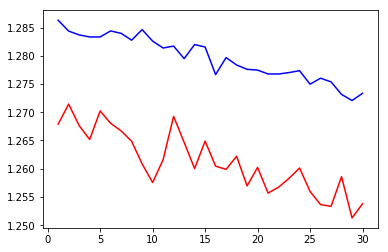

ideal VRMSE = 1.2512854235372262
------------NEW ITERATION-------------
For the following parameters:
F = 20
gradientLearningRateW = 0.0001
gradientLearningRateA = 0.0001
gradientLearningRateB = 0.0001
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


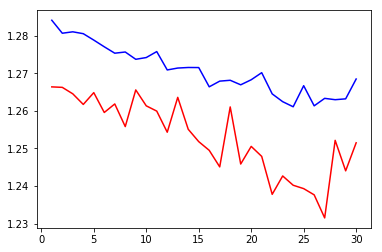

ideal VRMSE = 1.2315361931652062
------------NEW ITERATION-------------
For the following parameters:
F = 30
gradientLearningRateW = 0.0001
gradientLearningRateA = 0.0001
gradientLearningRateB = 0.0001
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


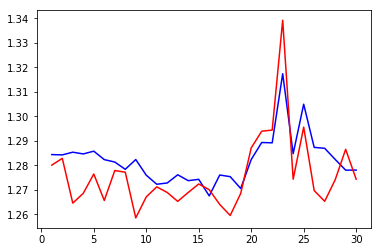

ideal VRMSE = 1.2585701521544401
------------NEW ITERATION-------------
For the following parameters:
F = 40
gradientLearningRateW = 0.0001
gradientLearningRateA = 0.0001
gradientLearningRateB = 0.0001
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


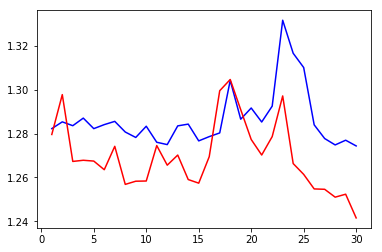

ideal VRMSE = 1.2415423534899035
------------NEW ITERATION-------------
For the following parameters:
F = 50
gradientLearningRateW = 0.0001
gradientLearningRateA = 0.0001
gradientLearningRateB = 0.0001
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


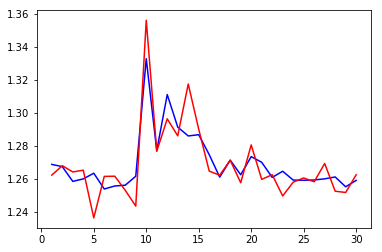

ideal VRMSE = 1.2363260669458458
------------NEW ITERATION-------------
For the following parameters:
F = 60
gradientLearningRateW = 0.0001
gradientLearningRateA = 0.0001
gradientLearningRateB = 0.0001
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


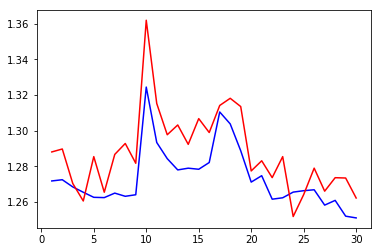

ideal VRMSE = 1.2517662001042216
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0001
gradientLearningRateA = 0.0001
gradientLearningRateB = 0.0001
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


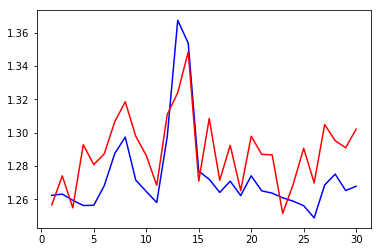

ideal VRMSE = 1.2514848712192557
------------NEW ITERATION-------------
For the following parameters:
F = 80
gradientLearningRateW = 0.0001
gradientLearningRateA = 0.0001
gradientLearningRateB = 0.0001
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


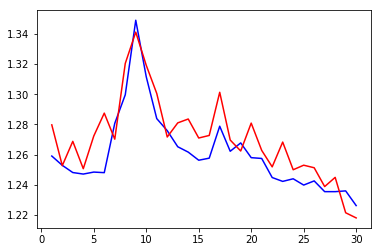

ideal VRMSE = 1.2179784500056825
------------NEW ITERATION-------------
For the following parameters:
F = 90
gradientLearningRateW = 0.0001
gradientLearningRateA = 0.0001
gradientLearningRateB = 0.0001
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


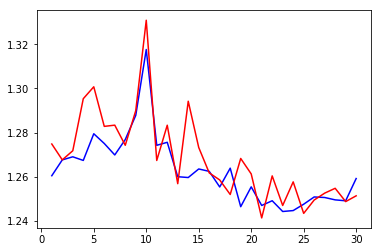

ideal VRMSE = 1.2412219575230954
------------NEW ITERATION-------------
For the following parameters:
F = 100
gradientLearningRateW = 0.0001
gradientLearningRateA = 0.0001
gradientLearningRateB = 0.0001
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


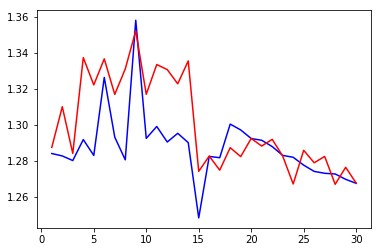

ideal VRMSE = 1.2668187785974239
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


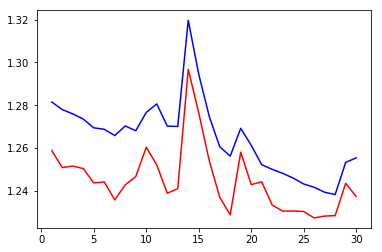

ideal VRMSE = 1.2272689608968503
------------NEW ITERATION-------------
For the following parameters:
F = 20
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


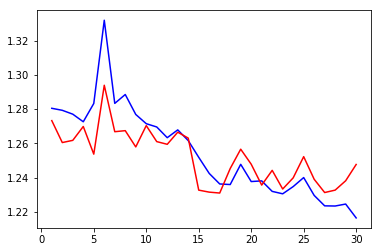

ideal VRMSE = 1.2309532174501503
------------NEW ITERATION-------------
For the following parameters:
F = 30
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


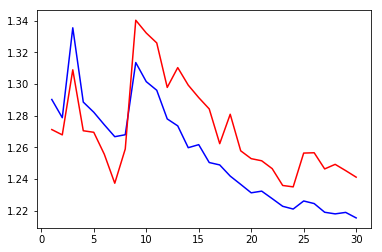

ideal VRMSE = 1.2350826723624133
------------NEW ITERATION-------------
For the following parameters:
F = 40
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


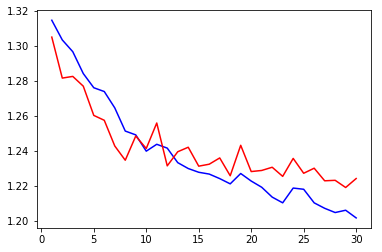

ideal VRMSE = 1.21896259246147
------------NEW ITERATION-------------
For the following parameters:
F = 50
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


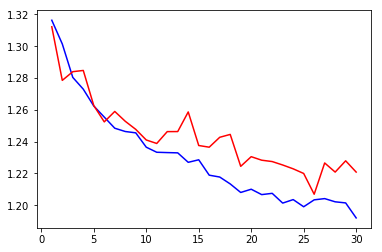

ideal VRMSE = 1.2069199145020812
------------NEW ITERATION-------------
For the following parameters:
F = 60
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


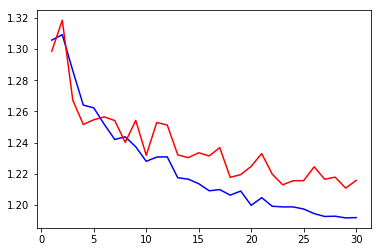

ideal VRMSE = 1.210791350631075
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


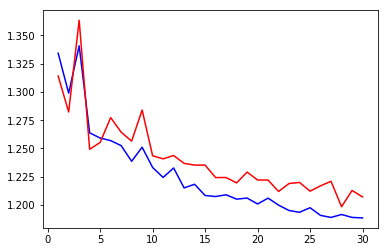

ideal VRMSE = 1.198492230391622
------------NEW ITERATION-------------
For the following parameters:
F = 80
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


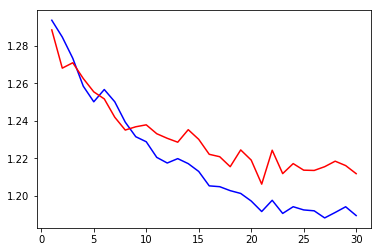

ideal VRMSE = 1.2061905349233912
------------NEW ITERATION-------------
For the following parameters:
F = 90
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


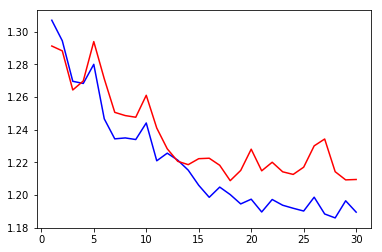

ideal VRMSE = 1.208864490774723
------------NEW ITERATION-------------
For the following parameters:
F = 100
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


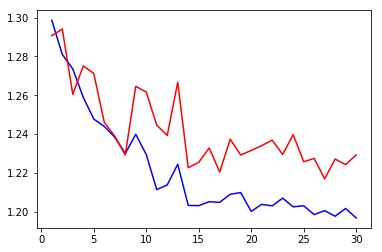

ideal VRMSE = 1.2169367007137475
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.001
gradientLearningRateA = 0.001
gradientLearningRateB = 0.001
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


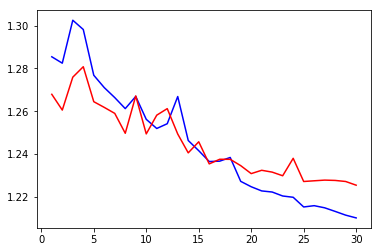

ideal VRMSE = 1.2254388548314479
------------NEW ITERATION-------------
For the following parameters:
F = 20
gradientLearningRateW = 0.001
gradientLearningRateA = 0.001
gradientLearningRateB = 0.001
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


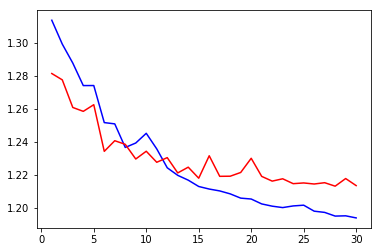

ideal VRMSE = 1.213252188367182
------------NEW ITERATION-------------
For the following parameters:
F = 30
gradientLearningRateW = 0.001
gradientLearningRateA = 0.001
gradientLearningRateB = 0.001
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


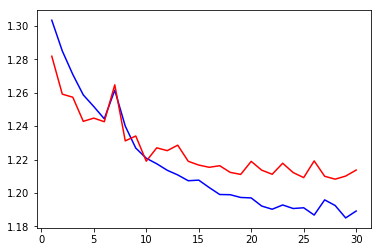

ideal VRMSE = 1.2082161031506593
------------NEW ITERATION-------------
For the following parameters:
F = 40
gradientLearningRateW = 0.001
gradientLearningRateA = 0.001
gradientLearningRateB = 0.001
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


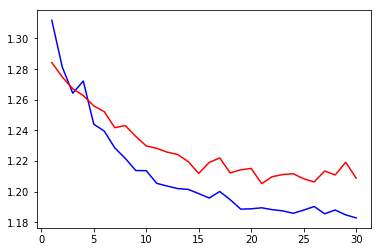

ideal VRMSE = 1.2053432874667054
------------NEW ITERATION-------------
For the following parameters:
F = 50
gradientLearningRateW = 0.001
gradientLearningRateA = 0.001
gradientLearningRateB = 0.001
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


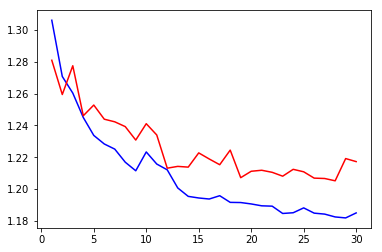

ideal VRMSE = 1.2051629283884708
------------NEW ITERATION-------------
For the following parameters:
F = 60
gradientLearningRateW = 0.001
gradientLearningRateA = 0.001
gradientLearningRateB = 0.001
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


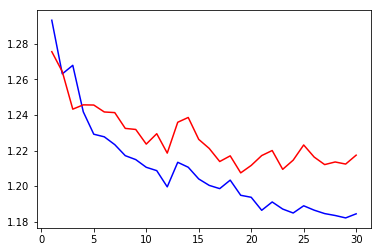

ideal VRMSE = 1.2074394260876853
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.001
gradientLearningRateA = 0.001
gradientLearningRateB = 0.001
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


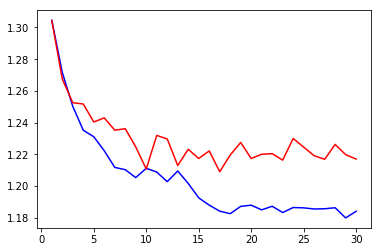

ideal VRMSE = 1.2091047636931627
------------NEW ITERATION-------------
For the following parameters:
F = 80
gradientLearningRateW = 0.001
gradientLearningRateA = 0.001
gradientLearningRateB = 0.001
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


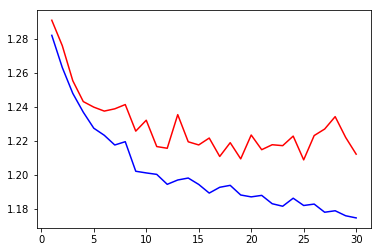

ideal VRMSE = 1.208917006967345
------------NEW ITERATION-------------
For the following parameters:
F = 90
gradientLearningRateW = 0.001
gradientLearningRateA = 0.001
gradientLearningRateB = 0.001
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


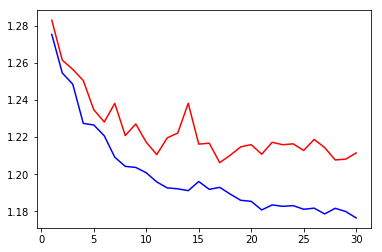

ideal VRMSE = 1.2062334528083922
------------NEW ITERATION-------------
For the following parameters:
F = 100
gradientLearningRateW = 0.001
gradientLearningRateA = 0.001
gradientLearningRateB = 0.001
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


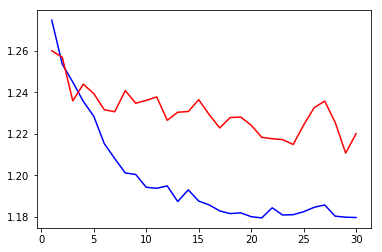

ideal VRMSE = 1.2107618055512153
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


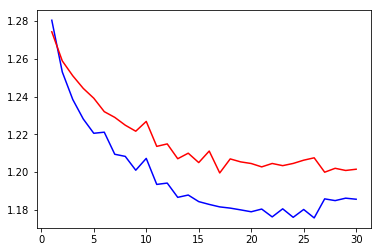

ideal VRMSE = 1.1995704785480708
------------NEW ITERATION-------------
For the following parameters:
F = 20
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


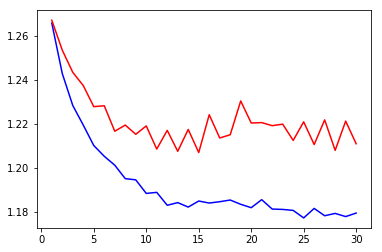

ideal VRMSE = 1.20686282360911
------------NEW ITERATION-------------
For the following parameters:
F = 30
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


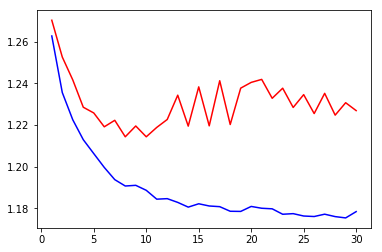

ideal VRMSE = 1.2143232162718844
------------NEW ITERATION-------------
For the following parameters:
F = 40
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


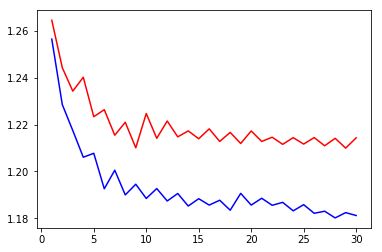

ideal VRMSE = 1.2099362561659732
------------NEW ITERATION-------------
For the following parameters:
F = 50
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


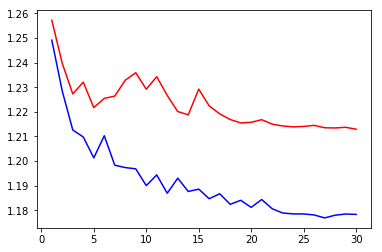

ideal VRMSE = 1.2129193553470468
------------NEW ITERATION-------------
For the following parameters:
F = 60
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


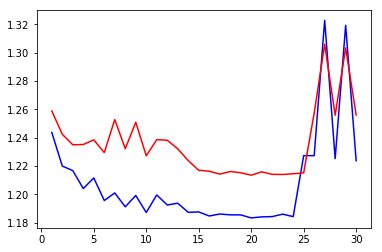

ideal VRMSE = 1.2135805252267429
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


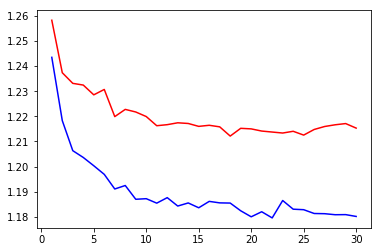

ideal VRMSE = 1.2121298245828727
------------NEW ITERATION-------------
For the following parameters:
F = 80
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


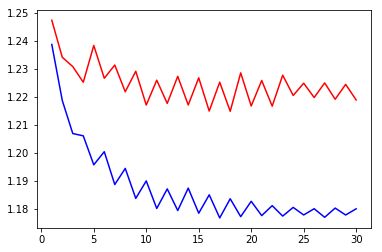

ideal VRMSE = 1.2147796383512388
------------NEW ITERATION-------------
For the following parameters:
F = 90
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


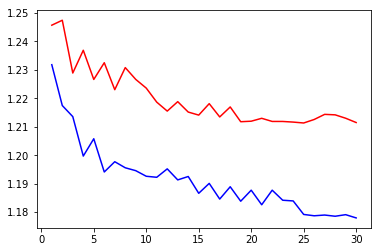

ideal VRMSE = 1.2113087413611214
------------NEW ITERATION-------------
For the following parameters:
F = 100
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


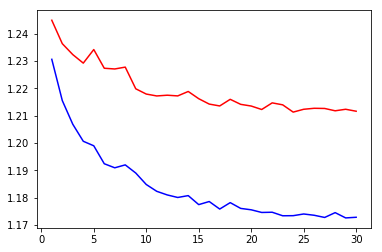

ideal VRMSE = 1.2113069226843978
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


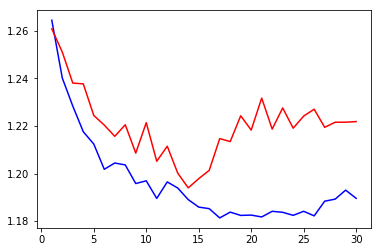

ideal VRMSE = 1.1939819643165193
------------NEW ITERATION-------------
For the following parameters:
F = 20
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


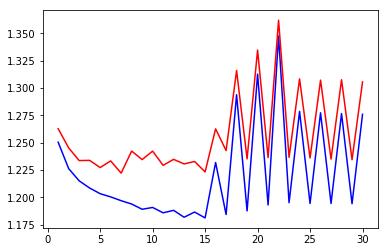

ideal VRMSE = 1.222045648673886
------------NEW ITERATION-------------
For the following parameters:
F = 30
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


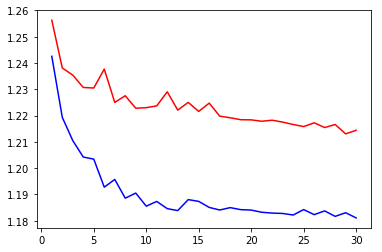

ideal VRMSE = 1.2130105557991675
------------NEW ITERATION-------------
For the following parameters:
F = 40
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


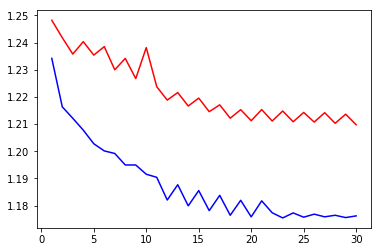

ideal VRMSE = 1.2097480145551527
------------NEW ITERATION-------------
For the following parameters:
F = 50
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


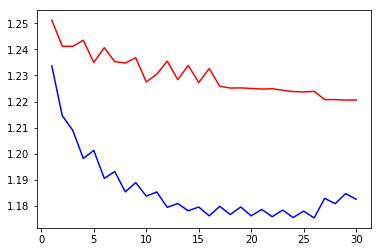

ideal VRMSE = 1.2205636045655692
------------NEW ITERATION-------------
For the following parameters:
F = 60
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


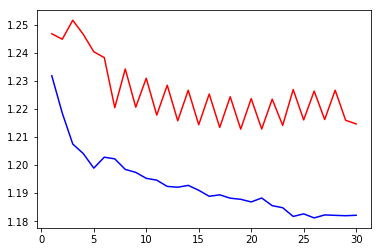

ideal VRMSE = 1.212792547085296
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


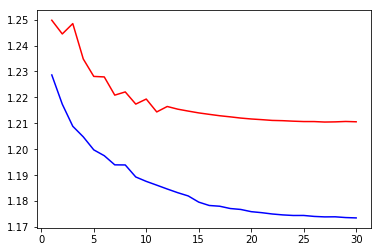

ideal VRMSE = 1.210502155581456
------------NEW ITERATION-------------
For the following parameters:
F = 80
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


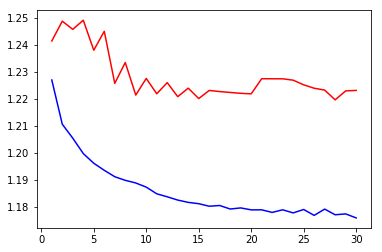

ideal VRMSE = 1.2195189136355147
------------NEW ITERATION-------------
For the following parameters:
F = 90
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


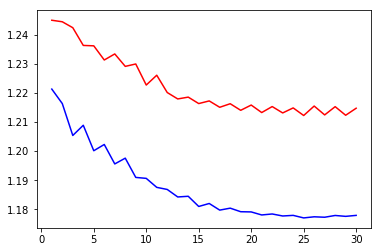

ideal VRMSE = 1.2122565565030268
------------NEW ITERATION-------------
For the following parameters:
F = 100
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


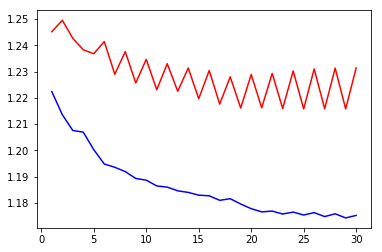

ideal VRMSE = 1.215782258942824
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.05
gradientLearningRateA = 0.05
gradientLearningRateB = 0.05
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


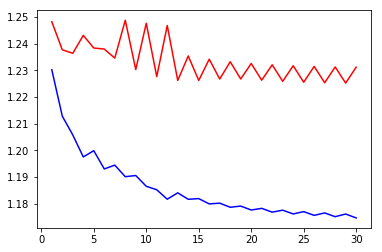

ideal VRMSE = 1.2251970553361193
------------NEW ITERATION-------------
For the following parameters:
F = 20
gradientLearningRateW = 0.05
gradientLearningRateA = 0.05
gradientLearningRateB = 0.05
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


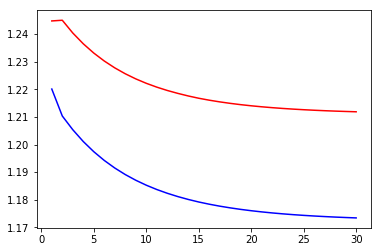

ideal VRMSE = 1.2118533789933361
------------NEW ITERATION-------------
For the following parameters:
F = 30
gradientLearningRateW = 0.05
gradientLearningRateA = 0.05
gradientLearningRateB = 0.05
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


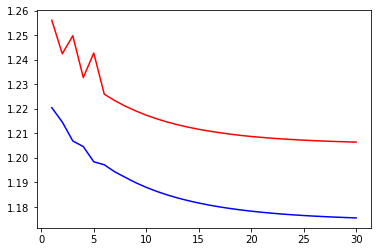

ideal VRMSE = 1.2064417935557643
------------NEW ITERATION-------------
For the following parameters:
F = 40
gradientLearningRateW = 0.05
gradientLearningRateA = 0.05
gradientLearningRateB = 0.05
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


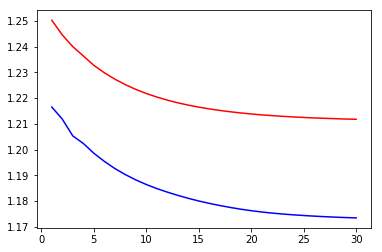

ideal VRMSE = 1.2117718098113655
------------NEW ITERATION-------------
For the following parameters:
F = 50
gradientLearningRateW = 0.05
gradientLearningRateA = 0.05
gradientLearningRateB = 0.05
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


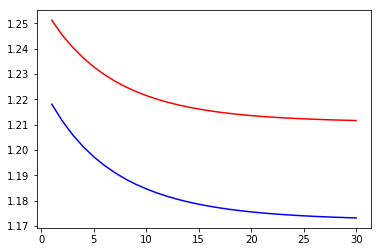

ideal VRMSE = 1.2116795508910578
------------NEW ITERATION-------------
For the following parameters:
F = 60
gradientLearningRateW = 0.05
gradientLearningRateA = 0.05
gradientLearningRateB = 0.05
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


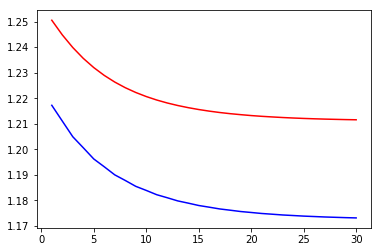

ideal VRMSE = 1.2115427102573415
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.05
gradientLearningRateA = 0.05
gradientLearningRateB = 0.05
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


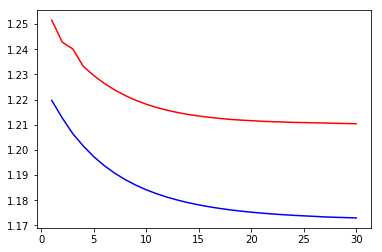

ideal VRMSE = 1.2103924764525316
------------NEW ITERATION-------------
For the following parameters:
F = 80
gradientLearningRateW = 0.05
gradientLearningRateA = 0.05
gradientLearningRateB = 0.05
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


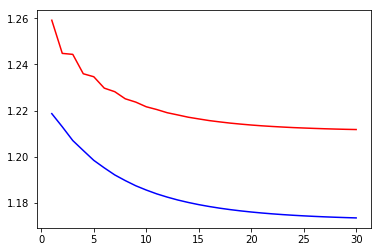

ideal VRMSE = 1.2117773477701304
------------NEW ITERATION-------------
For the following parameters:
F = 90
gradientLearningRateW = 0.05
gradientLearningRateA = 0.05
gradientLearningRateB = 0.05
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


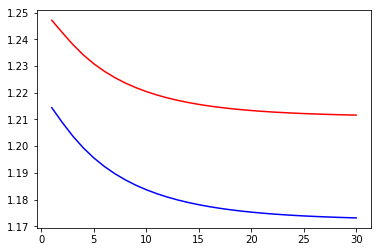

ideal VRMSE = 1.2116184190262174
------------NEW ITERATION-------------
For the following parameters:
F = 100
gradientLearningRateW = 0.05
gradientLearningRateA = 0.05
gradientLearningRateB = 0.05
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


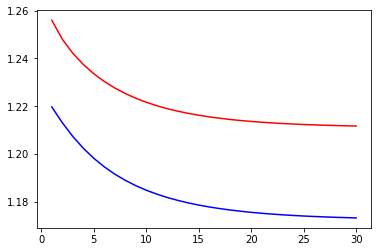

ideal VRMSE = 1.2116788692562288
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.1
gradientLearningRateA = 0.1
gradientLearningRateB = 0.1
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


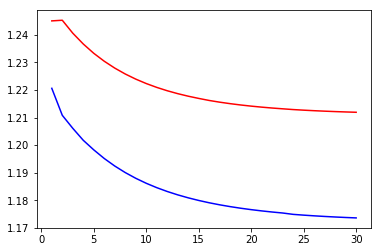

ideal VRMSE = 1.2119202161503826
------------NEW ITERATION-------------
For the following parameters:
F = 20
gradientLearningRateW = 0.1
gradientLearningRateA = 0.1
gradientLearningRateB = 0.1
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


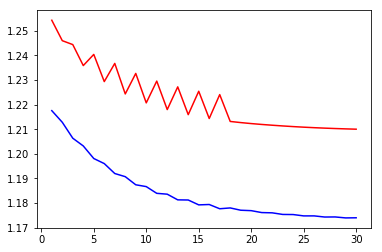

ideal VRMSE = 1.2100264848912603
------------NEW ITERATION-------------
For the following parameters:
F = 30
gradientLearningRateW = 0.1
gradientLearningRateA = 0.1
gradientLearningRateB = 0.1
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


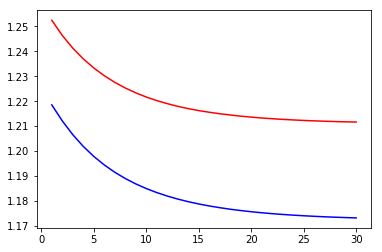

ideal VRMSE = 1.2116464634136168
------------NEW ITERATION-------------
For the following parameters:
F = 40
gradientLearningRateW = 0.1
gradientLearningRateA = 0.1
gradientLearningRateB = 0.1
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


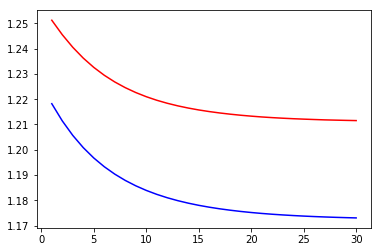

ideal VRMSE = 1.2115268034010553
------------NEW ITERATION-------------
For the following parameters:
F = 50
gradientLearningRateW = 0.1
gradientLearningRateA = 0.1
gradientLearningRateB = 0.1
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


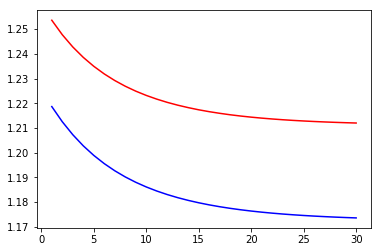

ideal VRMSE = 1.2119920791196648
------------NEW ITERATION-------------
For the following parameters:
F = 60
gradientLearningRateW = 0.1
gradientLearningRateA = 0.1
gradientLearningRateB = 0.1
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


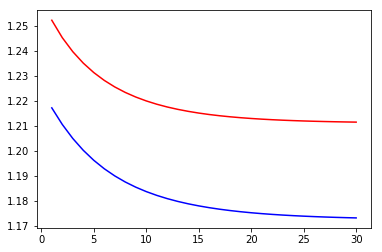

ideal VRMSE = 1.211453448155336
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.1
gradientLearningRateA = 0.1
gradientLearningRateB = 0.1
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


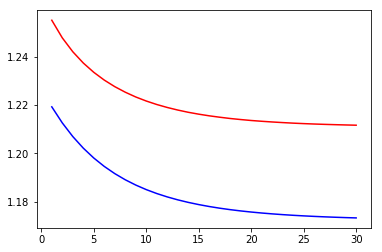

ideal VRMSE = 1.2116272613011043
------------NEW ITERATION-------------
For the following parameters:
F = 80
gradientLearningRateW = 0.1
gradientLearningRateA = 0.1
gradientLearningRateB = 0.1
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


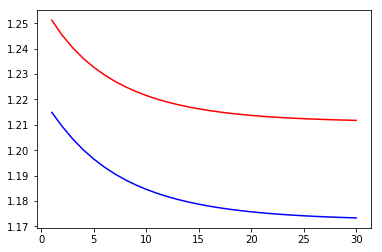

ideal VRMSE = 1.2117562453423008
------------NEW ITERATION-------------
For the following parameters:
F = 90
gradientLearningRateW = 0.1
gradientLearningRateA = 0.1
gradientLearningRateB = 0.1
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


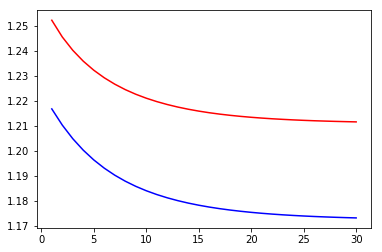

ideal VRMSE = 1.2115970615858747
------------NEW ITERATION-------------
For the following parameters:
F = 100
gradientLearningRateW = 0.1
gradientLearningRateA = 0.1
gradientLearningRateB = 0.1
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


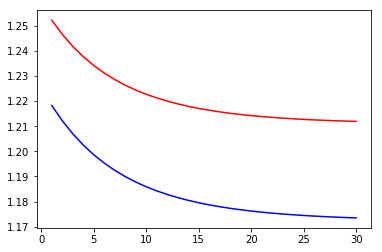

ideal VRMSE = 1.2119143079443715
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.5
gradientLearningRateA = 0.5
gradientLearningRateB = 0.5
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


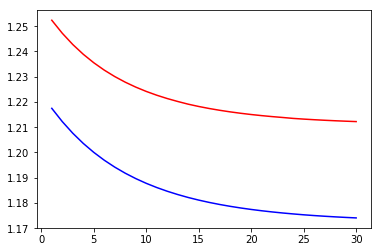

ideal VRMSE = 1.2122249301486412
------------NEW ITERATION-------------
For the following parameters:
F = 20
gradientLearningRateW = 0.5
gradientLearningRateA = 0.5
gradientLearningRateB = 0.5
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


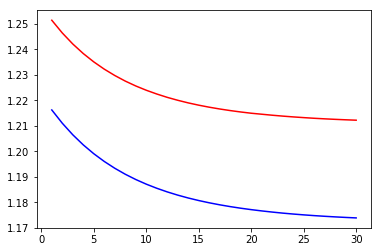

ideal VRMSE = 1.2122481212667449
------------NEW ITERATION-------------
For the following parameters:
F = 30
gradientLearningRateW = 0.5
gradientLearningRateA = 0.5
gradientLearningRateB = 0.5
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


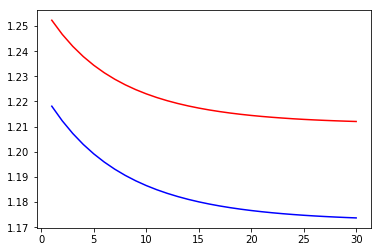

ideal VRMSE = 1.2120526632878184
------------NEW ITERATION-------------
For the following parameters:
F = 40
gradientLearningRateW = 0.5
gradientLearningRateA = 0.5
gradientLearningRateB = 0.5
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


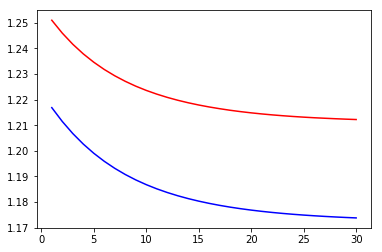

ideal VRMSE = 1.2122401730772063
------------NEW ITERATION-------------
For the following parameters:
F = 50
gradientLearningRateW = 0.5
gradientLearningRateA = 0.5
gradientLearningRateB = 0.5
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


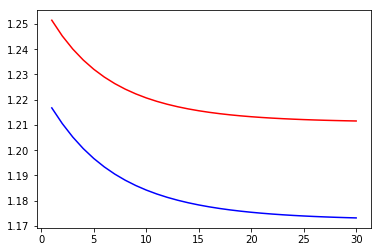

ideal VRMSE = 1.21157212401351
------------NEW ITERATION-------------
For the following parameters:
F = 60
gradientLearningRateW = 0.5
gradientLearningRateA = 0.5
gradientLearningRateB = 0.5
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


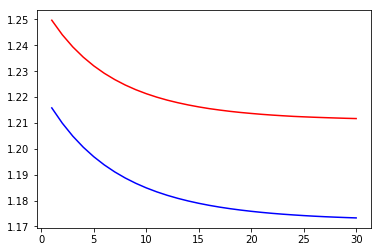

ideal VRMSE = 1.211689524587407
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.5
gradientLearningRateA = 0.5
gradientLearningRateB = 0.5
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


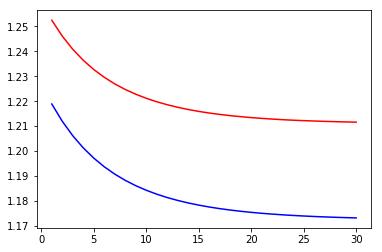

ideal VRMSE = 1.2115651123622861
------------NEW ITERATION-------------
For the following parameters:
F = 80
gradientLearningRateW = 0.5
gradientLearningRateA = 0.5
gradientLearningRateB = 0.5
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


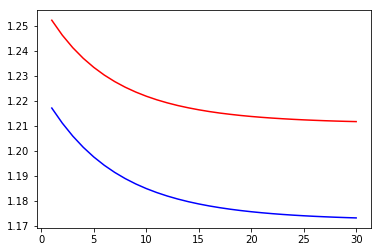

ideal VRMSE = 1.2117324557872509
------------NEW ITERATION-------------
For the following parameters:
F = 90
gradientLearningRateW = 0.5
gradientLearningRateA = 0.5
gradientLearningRateB = 0.5
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


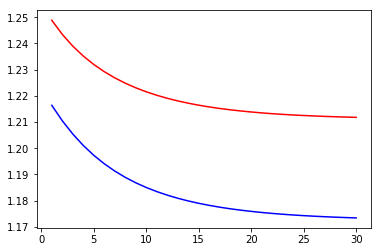

ideal VRMSE = 1.2117749066284298
------------NEW ITERATION-------------
For the following parameters:
F = 100
gradientLearningRateW = 0.5
gradientLearningRateA = 0.5
gradientLearningRateB = 0.5
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


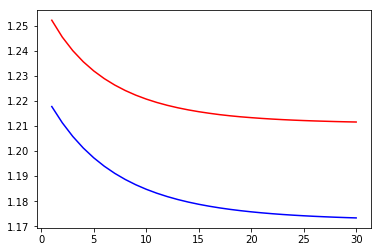

ideal VRMSE = 1.2115670909926088
---------------COMPLETED SEARCH-------------------------


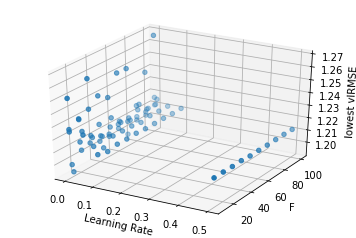

In [122]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

grad = []
hidden_nodes = []
error = []
[0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5]
for i in [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5]:
    learn_rate = i
    for j in range(1,11):
        F = 10*j
        RMSE = test(F,30,learn_rate,learn_rate,learn_rate,0,0,1,0)
        grad.append(learn_rate)
        hidden_nodes.append(F)
        error.append(RMSE)

print("---------------COMPLETED SEARCH-------------------------")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(grad, hidden_nodes, error)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('F')
ax.set_zlabel('lowest vlRMSE')
plt.show()

In [136]:
results = np.transpose(np.array([hidden_nodes, grad, error]))
best = np.array([[x[0],x[1],x[2]] for x in results if x[2] < 1.20])
print(best)

[[  7.00000000e+01   5.00000000e-04   1.19849223e+00]
 [  1.00000000e+01   5.00000000e-03   1.19957048e+00]
 [  1.00000000e+01   1.00000000e-02   1.19398196e+00]]


------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


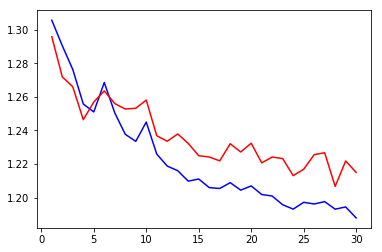

ideal VRMSE = 1.2066656537266272
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 5
annealing constant = 0

----------------RESULTS-------------------


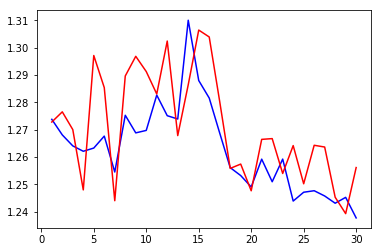

ideal VRMSE = 1.2393005501855474
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 10
annealing constant = 0

----------------RESULTS-------------------


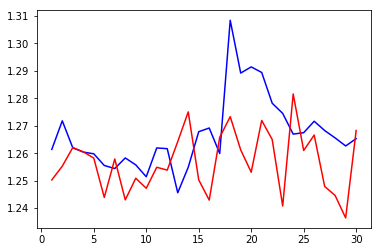

ideal VRMSE = 1.2364334759925344
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 15
annealing constant = 0

----------------RESULTS-------------------


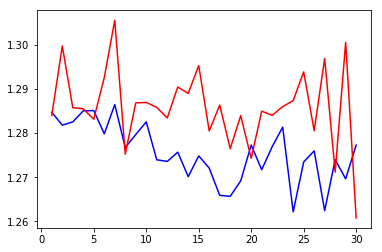

ideal VRMSE = 1.260785145866794
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 20
annealing constant = 0

----------------RESULTS-------------------


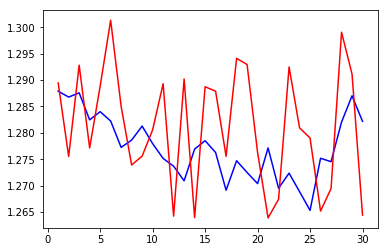

ideal VRMSE = 1.2638841479281016
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 25
annealing constant = 0

----------------RESULTS-------------------


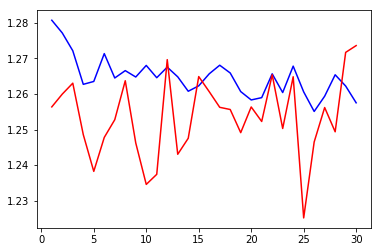

ideal VRMSE = 1.22515092654718
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 30
annealing constant = 0

----------------RESULTS-------------------


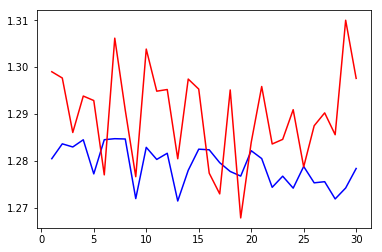

ideal VRMSE = 1.2678665118611498
---------------------------------------------------
For F and learning rate = [70, 0.00050000000000000001]


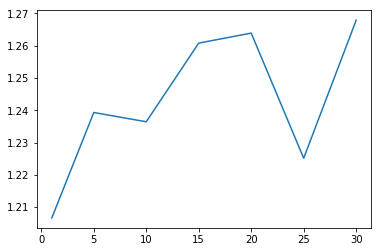

------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


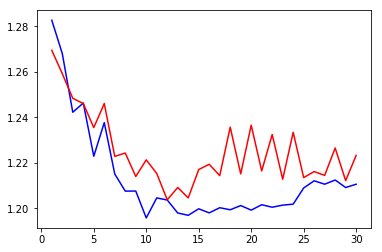

ideal VRMSE = 1.2037937690058964
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 5
annealing constant = 0

----------------RESULTS-------------------


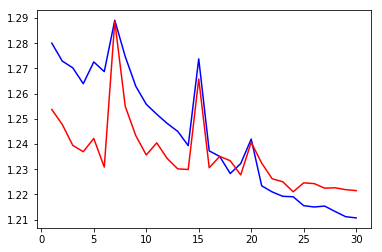

ideal VRMSE = 1.221013158872504
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 10
annealing constant = 0

----------------RESULTS-------------------


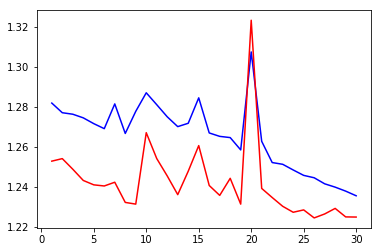

ideal VRMSE = 1.2243304347741442
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 15
annealing constant = 0

----------------RESULTS-------------------


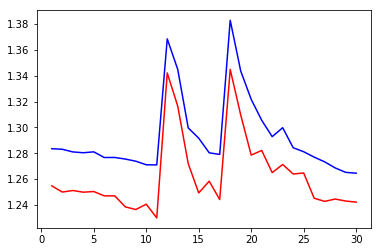

ideal VRMSE = 1.2299474751633954
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 20
annealing constant = 0

----------------RESULTS-------------------


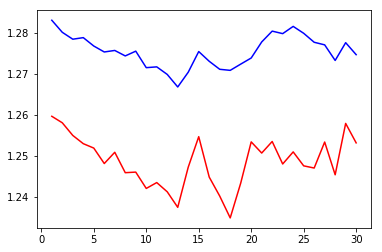

ideal VRMSE = 1.2349322205208983
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 25
annealing constant = 0

----------------RESULTS-------------------


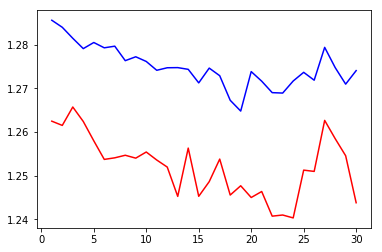

ideal VRMSE = 1.2402936586236981
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 30
annealing constant = 0

----------------RESULTS-------------------


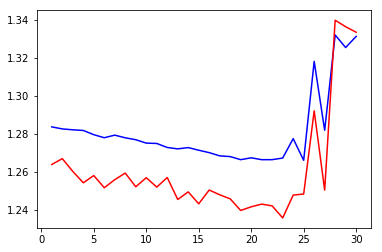

ideal VRMSE = 1.2357470406578852
---------------------------------------------------
For F and learning rate = [10, 0.0050000000000000001]


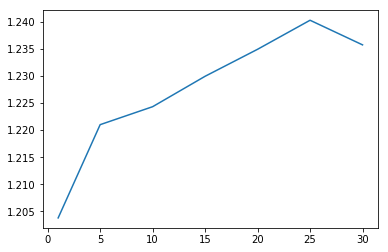

------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


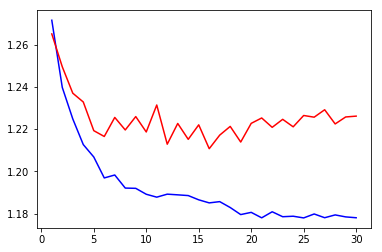

ideal VRMSE = 1.2107613491200468
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 5
annealing constant = 0

----------------RESULTS-------------------


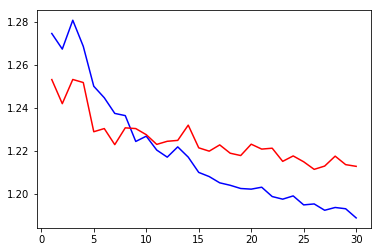

ideal VRMSE = 1.2114700762344552
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 10
annealing constant = 0

----------------RESULTS-------------------


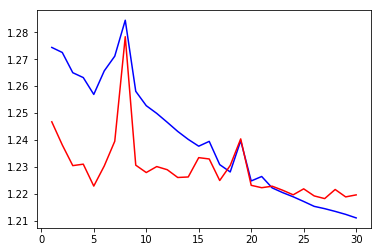

ideal VRMSE = 1.2182212248783078
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 15
annealing constant = 0

----------------RESULTS-------------------


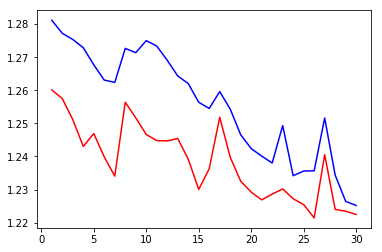

ideal VRMSE = 1.2214394473311094
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 20
annealing constant = 0

----------------RESULTS-------------------


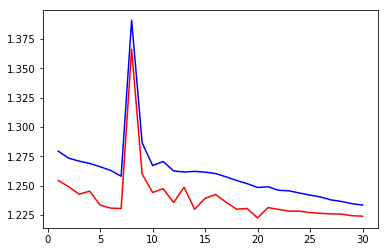

ideal VRMSE = 1.222484589005972
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 25
annealing constant = 0

----------------RESULTS-------------------


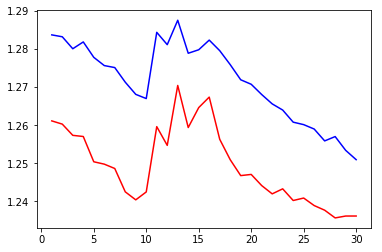

ideal VRMSE = 1.2356143718434118
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 30
annealing constant = 0

----------------RESULTS-------------------


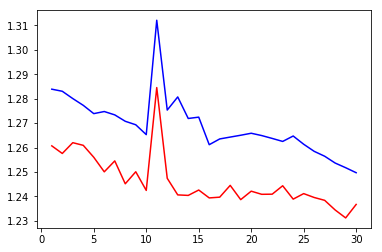

ideal VRMSE = 1.2311970441371842
---------------------------------------------------
For F and learning rate = [10, 0.01]


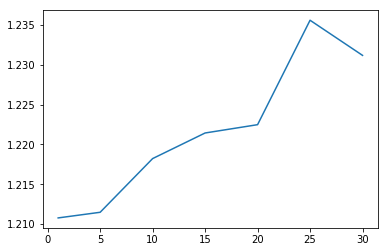

------------COMPLETED----------------


In [146]:
import matplotlib.pyplot as plt

for x in best:
    batch_size = []
    error = []
    F = int(x[0])
    learn_rate = x[1]
    for j in [1,5,10,15,20,25,30]:
        size = j
        RMSE = test(F,30,learn_rate,learn_rate,learn_rate,0,0,size,0)
        batch_size.append(size)
        error.append(RMSE)
    print('---------------------------------------------------')
    print("For F and learning rate = {}".format([F,learn_rate]))
    plt.plot(batch_size,error)
    plt.show()
print("------------COMPLETED----------------")

------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0.01
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


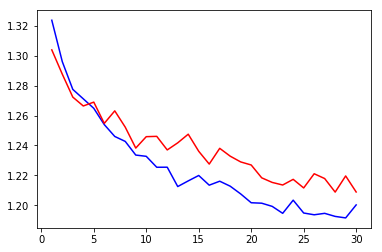

ideal VRMSE = 1.2088618118493346
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0.05
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


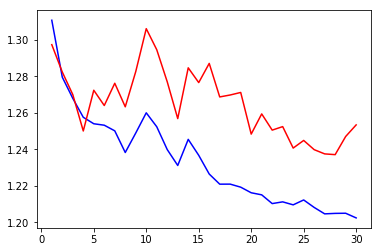

ideal VRMSE = 1.2370806914708075
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0.1
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


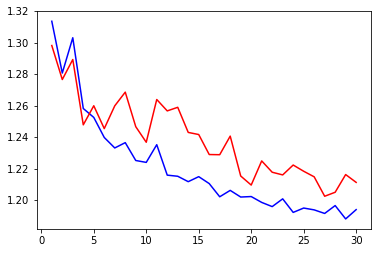

ideal VRMSE = 1.202395930802618
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0.5
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


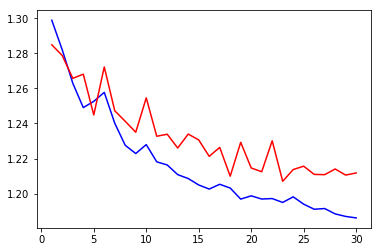

ideal VRMSE = 1.2069926437045229
---------------------------------------------------
For F and learning rate = [70, 0.00050000000000000001]


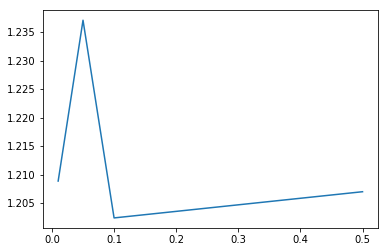

------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0.01
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


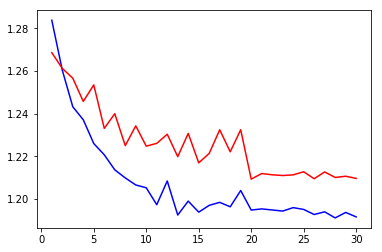

ideal VRMSE = 1.2092772406582175
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0.05
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


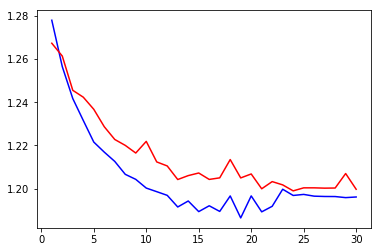

ideal VRMSE = 1.19895397289268
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0.1
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


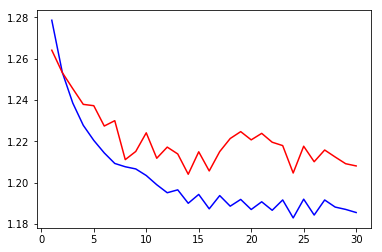

ideal VRMSE = 1.2040910391687412
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0.5
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


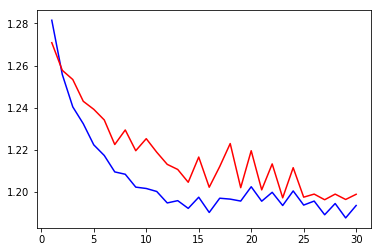

ideal VRMSE = 1.1962097554711892
---------------------------------------------------
For F and learning rate = [10, 0.0050000000000000001]


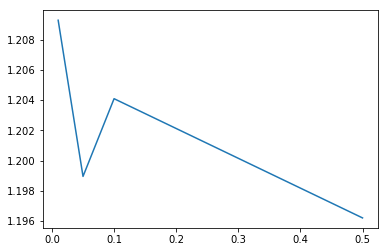

------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0.01
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


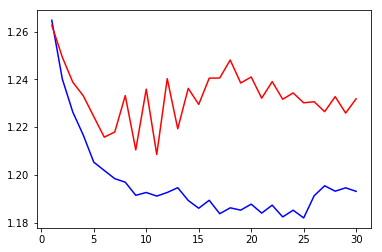

ideal VRMSE = 1.2085751228395616
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0.05
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


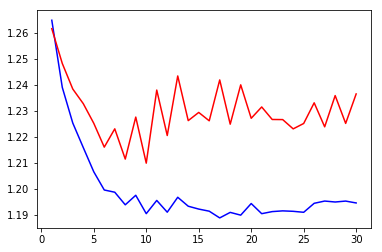

ideal VRMSE = 1.209841316318358
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0.1
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


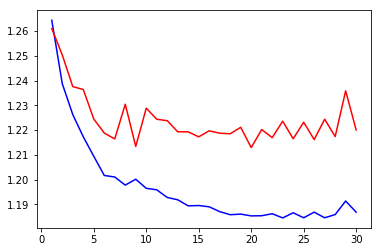

ideal VRMSE = 1.2129557538748592
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0.5
regularization constant = 0
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


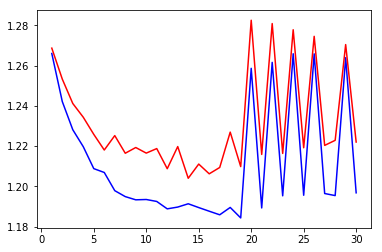

ideal VRMSE = 1.20400631764864
---------------------------------------------------
For F and learning rate = [10, 0.01]


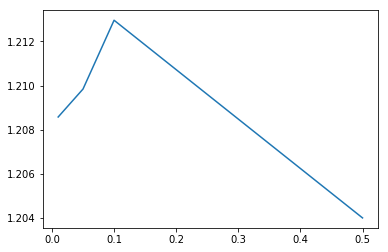

------------COMPLETED----------------


In [154]:
import matplotlib.pyplot as plt

for x in best:
    mom = []
    error = []
    F = int(x[0])
    learn_rate = x[1]
    for j in [0.01,0.05,0.1,0.5]:
        momentum = j
        RMSE = test(F,30,learn_rate,learn_rate,learn_rate,momentum,0,1,0)
        mom.append(momentum)
        error.append(RMSE)
    print('---------------------------------------------------')
    print("For F and learning rate = {}".format([F,learn_rate]))
    plt.plot(mom,error)
    plt.show()
print("------------COMPLETED----------------")

------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0.1
regularization constant = 0.0001
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


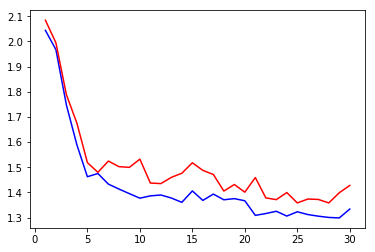

ideal VRMSE = 1.358017130346959
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0.1
regularization constant = 0.0005
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


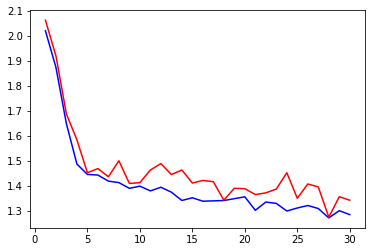

ideal VRMSE = 1.2748580932381206
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0.1
regularization constant = 0.001
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


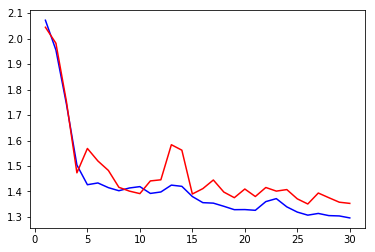

ideal VRMSE = 1.3510230042063447
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0.1
regularization constant = 0.005
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


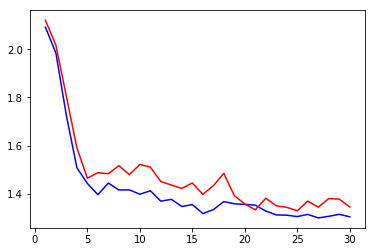

ideal VRMSE = 1.3306112564492583
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0.1
regularization constant = 0.01
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


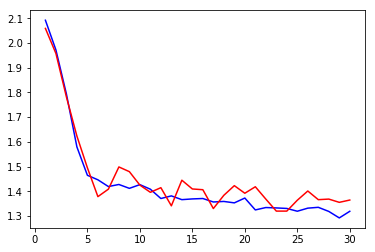

ideal VRMSE = 1.320287050128434
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0.1
regularization constant = 0.05
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


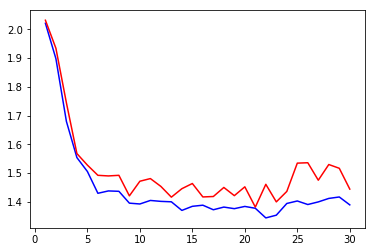

ideal VRMSE = 1.381075096094572
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0.1
regularization constant = 0.1
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


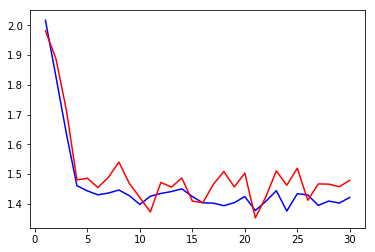

ideal VRMSE = 1.3525803799443958
------------NEW ITERATION-------------
For the following parameters:
F = 70
gradientLearningRateW = 0.0005
gradientLearningRateA = 0.0005
gradientLearningRateB = 0.0005
epochs = 30
momentum constant= 0.1
regularization constant = 0.5
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


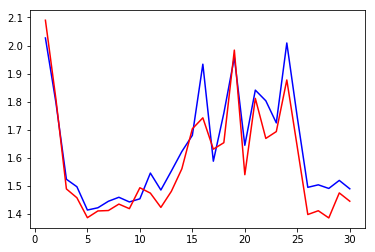

ideal VRMSE = 1.3856406460551018
---------------------------------------------------
For F and learning rate = [70, 0.0005]


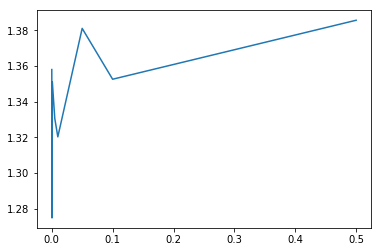

------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0.5
regularization constant = 0.0001
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


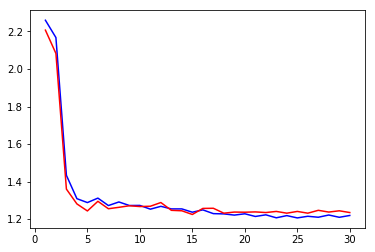

ideal VRMSE = 1.2243150609304179
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0.5
regularization constant = 0.0005
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


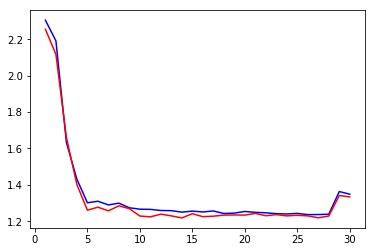

ideal VRMSE = 1.218281792655455
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


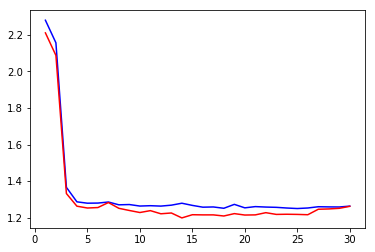

ideal VRMSE = 1.199122486171494
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0.5
regularization constant = 0.005
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


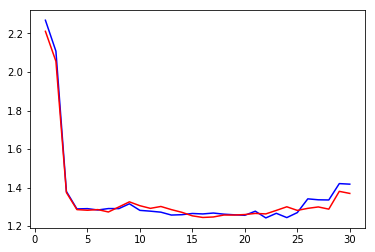

ideal VRMSE = 1.2447785683447985
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0.5
regularization constant = 0.01
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


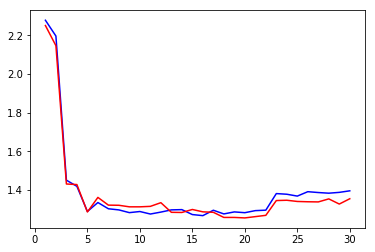

ideal VRMSE = 1.2557237376362516
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0.5
regularization constant = 0.05
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


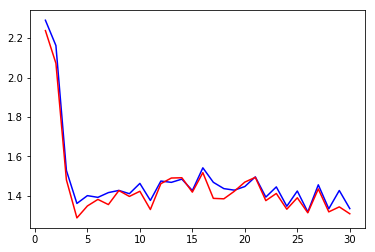

ideal VRMSE = 1.2880013076162045
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0.5
regularization constant = 0.1
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


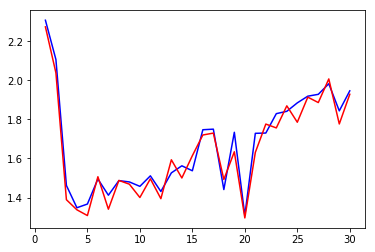

ideal VRMSE = 1.2953357622030301
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.005
gradientLearningRateA = 0.005
gradientLearningRateB = 0.005
epochs = 30
momentum constant= 0.5
regularization constant = 0.5
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


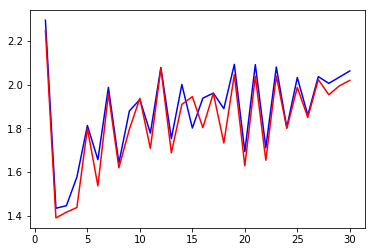

ideal VRMSE = 1.390191202298219
---------------------------------------------------
For F and learning rate = [10, 0.005]


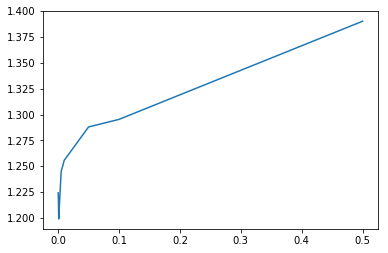

------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0.5
regularization constant = 0.0001
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


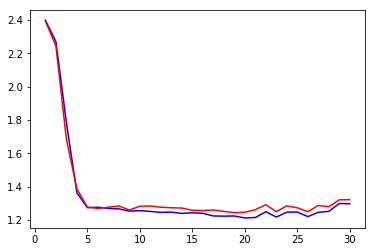

ideal VRMSE = 1.2439326432940938
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0.5
regularization constant = 0.0005
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


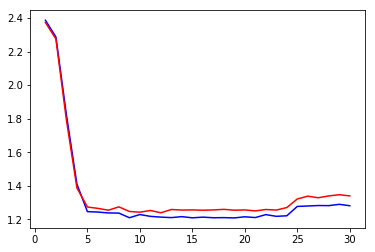

ideal VRMSE = 1.2396943596157715
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


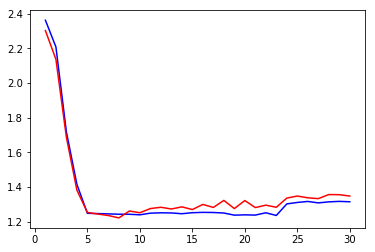

ideal VRMSE = 1.2208711298861454
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0.5
regularization constant = 0.005
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


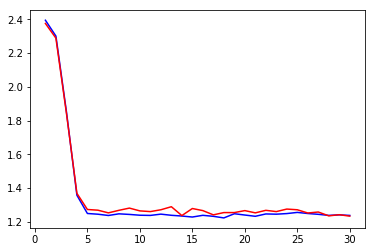

ideal VRMSE = 1.2337363021156078
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0.5
regularization constant = 0.01
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


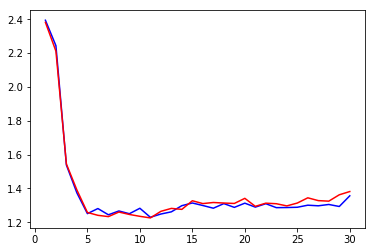

ideal VRMSE = 1.2251745310685116
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0.5
regularization constant = 0.05
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


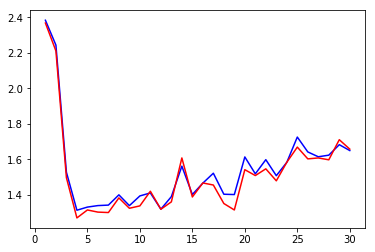

ideal VRMSE = 1.2690651345732706
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0.5
regularization constant = 0.1
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


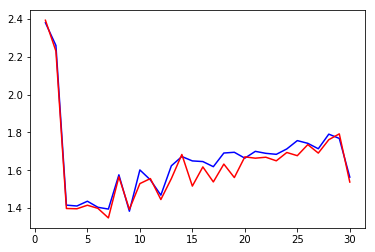

ideal VRMSE = 1.3479028545348355
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 0.01
gradientLearningRateA = 0.01
gradientLearningRateB = 0.01
epochs = 30
momentum constant= 0.5
regularization constant = 0.5
batch size = 1
annealing constant = 0

----------------RESULTS-------------------


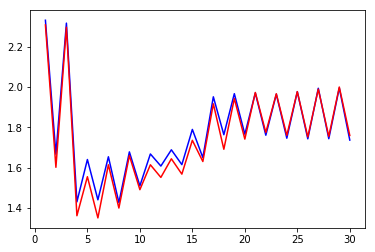

ideal VRMSE = 1.350243642731504
---------------------------------------------------
For F and learning rate = [10, 0.01]


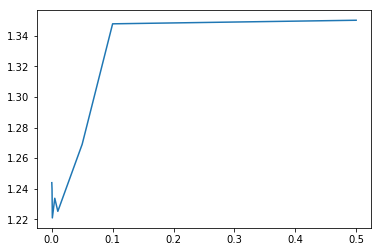

------------COMPLETED----------------


In [5]:
import matplotlib.pyplot as plt

best = [[70,0.0005,1,0.1],[10,0.005,1,0.5],[10,0.01,1,0.5]]
for x in best:
    regl = []
    error = []
    F = int(x[0])
    learn_rate = x[1]
    size = int(x[2])
    mom = x[3]
    for j in [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5]:
        reg = j
        RMSE = test(F,30,learn_rate,learn_rate,learn_rate,mom,reg,size,0)
        regl.append(reg)
        error.append(RMSE)
    print('---------------------------------------------------')
    print("For F and learning rate = {}".format([F,learn_rate]))
    plt.plot(regl,error)
    plt.show()
print("------------COMPLETED----------------")

------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 1.8774798231813214e-125
gradientLearningRateA = 1.8774798231813214e-125
gradientLearningRateB = 1.8774798231813214e-125
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 0.001

----------------RESULTS-------------------


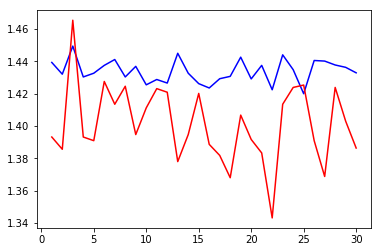

ideal VRMSE = 1.3432090404385273
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 1.720853047776566e-104
gradientLearningRateA = 1.720853047776566e-104
gradientLearningRateB = 1.720853047776566e-104
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 0.005

----------------RESULTS-------------------


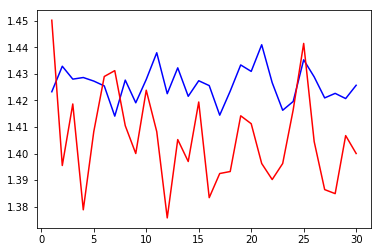

ideal VRMSE = 1.3757294715703985
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 1.8113182186397505e-95
gradientLearningRateA = 1.8113182186397505e-95
gradientLearningRateB = 1.8113182186397505e-95
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 0.01

----------------RESULTS-------------------


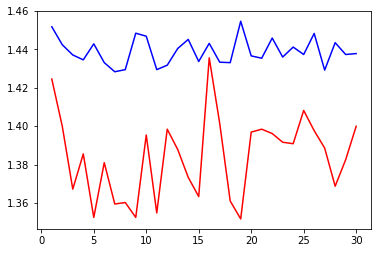

ideal VRMSE = 1.351801916351886
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 1.4405029971798924e-74
gradientLearningRateA = 1.4405029971798924e-74
gradientLearningRateB = 1.4405029971798924e-74
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 0.05

----------------RESULTS-------------------


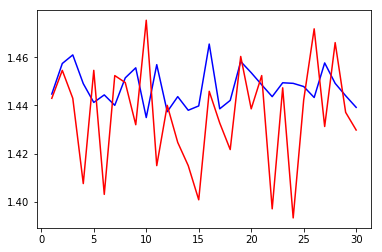

ideal VRMSE = 1.3932166491895461
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 1.2739358601451862e-65
gradientLearningRateA = 1.2739358601451862e-65
gradientLearningRateB = 1.2739358601451862e-65
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 0.1

----------------RESULTS-------------------


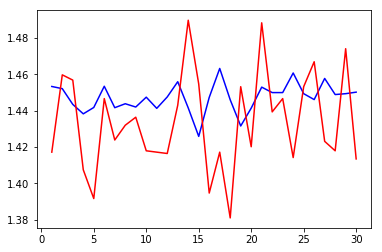

ideal VRMSE = 1.381075096094572
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 2.8055968468547314e-45
gradientLearningRateA = 2.8055968468547314e-45
gradientLearningRateB = 2.8055968468547314e-45
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 0.5

----------------RESULTS-------------------


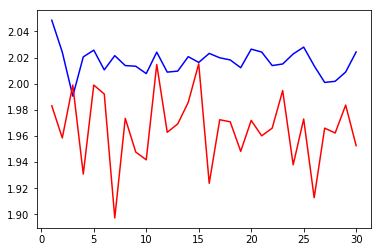

ideal VRMSE = 1.8973665961010275
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 6.08062520776759e-37
gradientLearningRateA = 6.08062520776759e-37
gradientLearningRateB = 6.08062520776759e-37
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 1

----------------RESULTS-------------------


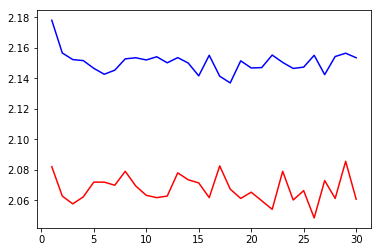

ideal VRMSE = 2.0483626323686464
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 5.4077764741882067e-20
gradientLearningRateA = 5.4077764741882067e-20
gradientLearningRateB = 5.4077764741882067e-20
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 5

----------------RESULTS-------------------


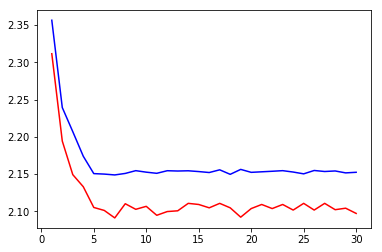

ideal VRMSE = 2.091083828770948
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 2.223760281554543e-14
gradientLearningRateA = 2.223760281554543e-14
gradientLearningRateB = 2.223760281554543e-14
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 10

----------------RESULTS-------------------


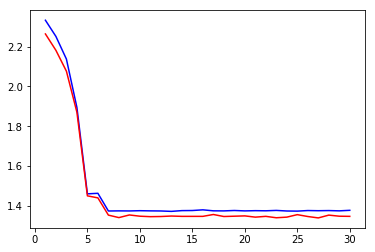

ideal VRMSE = 1.3392849624058039
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 1.0480826362422578e-11
gradientLearningRateA = 1.0480826362422578e-11
gradientLearningRateB = 1.0480826362422578e-11
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 15

----------------RESULTS-------------------


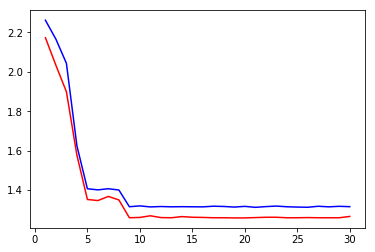

ideal VRMSE = 1.2590723402151034
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 4.294569334267845e-10
gradientLearningRateA = 4.294569334267845e-10
gradientLearningRateB = 4.294569334267845e-10
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 20

----------------RESULTS-------------------


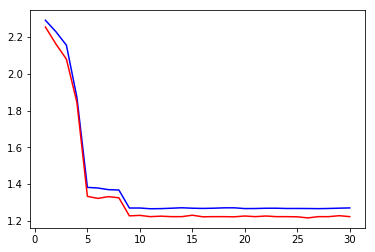

ideal VRMSE = 1.2156869403107466
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 5.298283981191502e-09
gradientLearningRateA = 5.298283981191502e-09
gradientLearningRateB = 5.298283981191502e-09
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 25

----------------RESULTS-------------------


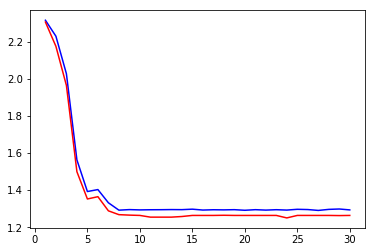

ideal VRMSE = 1.2498420952895988
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 3.281654619705489e-08
gradientLearningRateA = 3.281654619705489e-08
gradientLearningRateB = 3.281654619705489e-08
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 30

----------------RESULTS-------------------


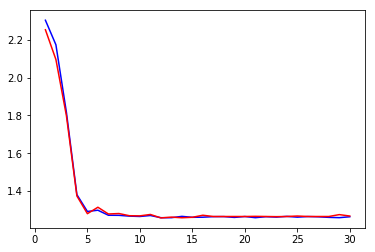

ideal VRMSE = 1.2573991536417333


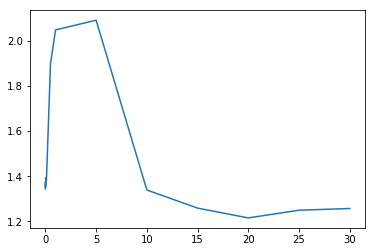

------------COMPLETED----------------


In [7]:
annealing = []
error =[]
for i in [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,15,20,25,30]:
    phi = i
    RMSE = test(10,30,0.005,0.005,0.005,0.5,0.001,1,phi)
    error.append(RMSE)
    annealing.append(phi)
plt.plot(annealing,error)
plt.show()
print("------------COMPLETED----------------")

------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 3.926537745531778e-07
gradientLearningRateA = 3.926537745531778e-07
gradientLearningRateB = 3.926537745531778e-07
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 40

----------------RESULTS-------------------


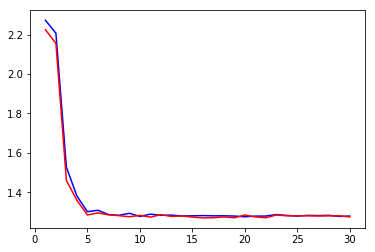

ideal VRMSE = 1.2698943180231055
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 1.9788700902750163e-06
gradientLearningRateA = 1.9788700902750163e-06
gradientLearningRateB = 1.9788700902750163e-06
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 50

----------------RESULTS-------------------


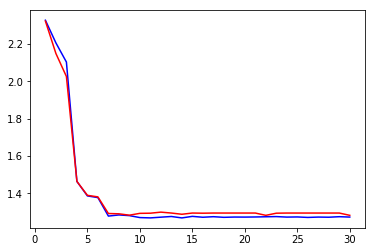

ideal VRMSE = 1.2830883794476842
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 6.190797167617124e-06
gradientLearningRateA = 6.190797167617124e-06
gradientLearningRateB = 6.190797167617124e-06
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 60

----------------RESULTS-------------------


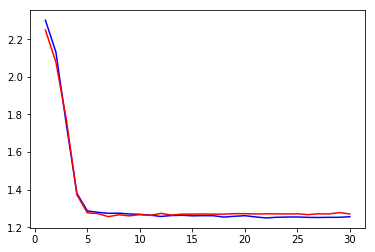

ideal VRMSE = 1.2573991536417333
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 1.4464805080843804e-05
gradientLearningRateA = 1.4464805080843804e-05
gradientLearningRateB = 1.4464805080843804e-05
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 70

----------------RESULTS-------------------


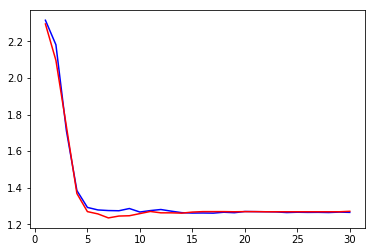

ideal VRMSE = 1.2345892135912209
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 2.7892002260097772e-05
gradientLearningRateA = 2.7892002260097772e-05
gradientLearningRateB = 2.7892002260097772e-05
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 80

----------------RESULTS-------------------


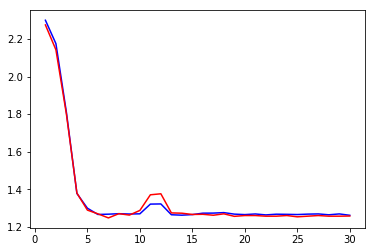

ideal VRMSE = 1.248156535392138
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 4.707466415459605e-05
gradientLearningRateA = 4.707466415459605e-05
gradientLearningRateB = 4.707466415459605e-05
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 90

----------------RESULTS-------------------


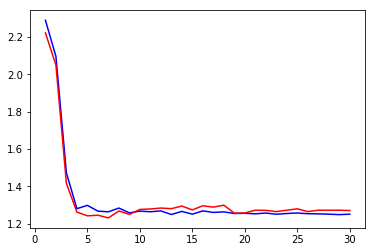

ideal VRMSE = 1.2320287077994996
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 7.215733798250827e-05
gradientLearningRateA = 7.215733798250827e-05
gradientLearningRateB = 7.215733798250827e-05
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 100

----------------RESULTS-------------------


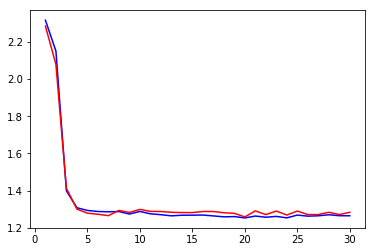

ideal VRMSE = 1.2582360250512785


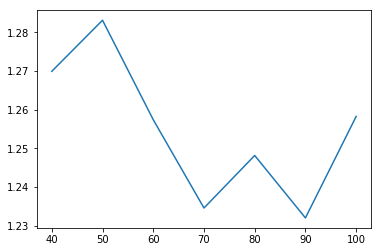

------------COMPLETED----------------


In [8]:
annealing = []
error =[]
for i in [40,50,60,70,80,90,100]:
    phi = i
    RMSE = test(10,30,0.005,0.005,0.005,0.5,0.001,1,phi)
    error.append(RMSE)
    annealing.append(phi)
plt.plot(annealing,error)
plt.show()
print("------------COMPLETED----------------")

------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 4.294569334267845e-10
gradientLearningRateA = 8.589138668535691e-12
gradientLearningRateB = 8.589138668535691e-12
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 20

----------------RESULTS-------------------


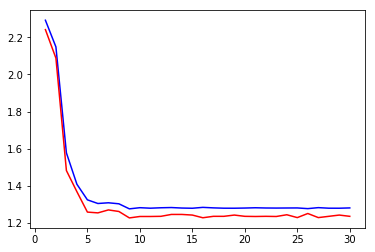

ideal VRMSE = 1.2277493315219647
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 4.294569334267845e-10
gradientLearningRateA = 4.294569334267843e-11
gradientLearningRateB = 4.294569334267843e-11
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 20

----------------RESULTS-------------------


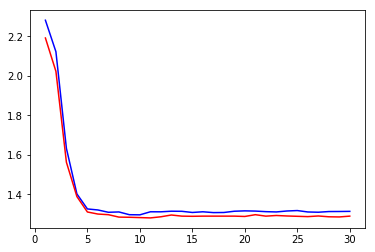

ideal VRMSE = 1.2806248474865698
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 4.294569334267845e-10
gradientLearningRateA = 8.589138668535686e-11
gradientLearningRateB = 8.589138668535686e-11
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 20

----------------RESULTS-------------------


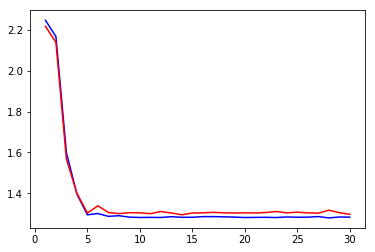

ideal VRMSE = 1.2953357622030301
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 4.294569334267845e-10
gradientLearningRateA = 4.294569334267845e-10
gradientLearningRateB = 4.294569334267845e-10
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 20

----------------RESULTS-------------------


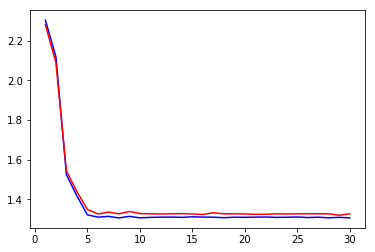

ideal VRMSE = 1.319489534471171
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 4.294569334267845e-10
gradientLearningRateA = 8.58913866853569e-10
gradientLearningRateB = 8.58913866853569e-10
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 20

----------------RESULTS-------------------


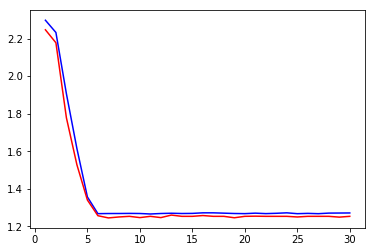

ideal VRMSE = 1.2447785683447985
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 4.294569334267845e-10
gradientLearningRateA = 4.294569334267845e-09
gradientLearningRateB = 4.294569334267845e-09
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 20

----------------RESULTS-------------------


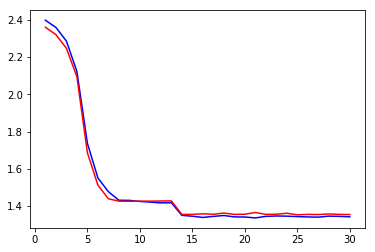

ideal VRMSE = 1.353358395757909
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 4.294569334267845e-10
gradientLearningRateA = 8.58913866853569e-09
gradientLearningRateB = 8.58913866853569e-09
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 20

----------------RESULTS-------------------


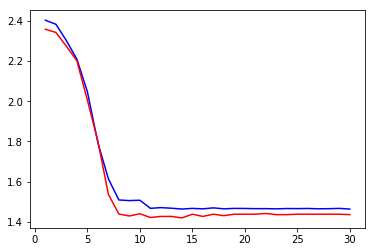

ideal VRMSE = 1.420896677602229
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 4.294569334267845e-10
gradientLearningRateA = 4.294569334267846e-08
gradientLearningRateB = 4.294569334267846e-08
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 20

----------------RESULTS-------------------


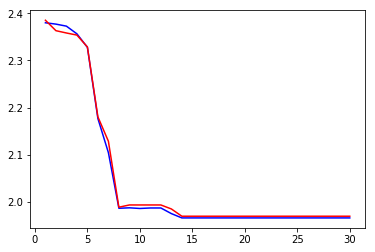

ideal VRMSE = 1.9692370951315397


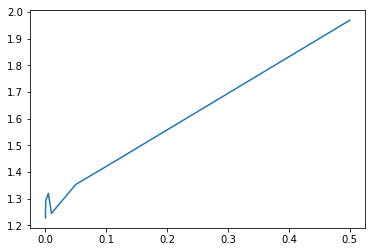

------------COMPLETED----------------


In [9]:
gradA = []
error =[]
for i in [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5]:
    RMSE = test(10,30,0.005,i,i,0.5,0.001,1,20)
    error.append(RMSE)
    gradA.append(i)
plt.plot(gradA,error)
plt.show()
print("------------COMPLETED----------------")

------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 4.294569334267845e-10
gradientLearningRateA = 8.589138668535689e-14
gradientLearningRateB = 8.589138668535689e-14
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 20

----------------RESULTS-------------------


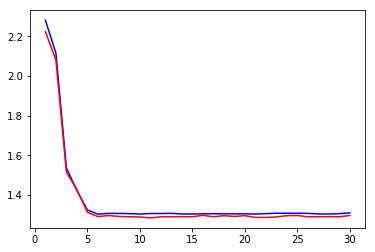

ideal VRMSE = 1.2839085063319655
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 4.294569334267845e-10
gradientLearningRateA = 4.2945693342678456e-13
gradientLearningRateB = 4.2945693342678456e-13
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 20

----------------RESULTS-------------------


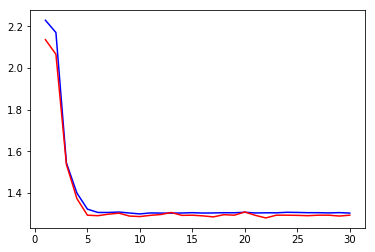

ideal VRMSE = 1.2798026163600795
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 4.294569334267845e-10
gradientLearningRateA = 8.589138668535691e-13
gradientLearningRateB = 8.589138668535691e-13
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 20

----------------RESULTS-------------------


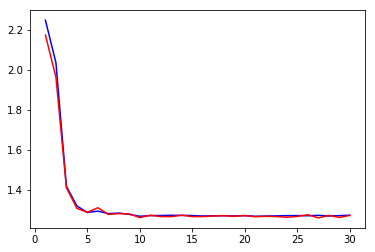

ideal VRMSE = 1.2607433062326867
------------NEW ITERATION-------------
For the following parameters:
F = 10
gradientLearningRateW = 4.294569334267845e-10
gradientLearningRateA = 4.2945693342678454e-12
gradientLearningRateB = 4.2945693342678454e-12
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 20

----------------RESULTS-------------------


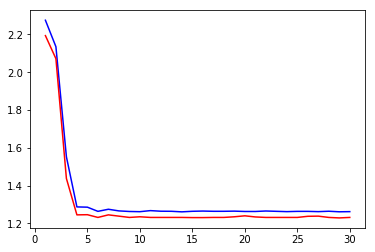

ideal VRMSE = 1.2294628694549588


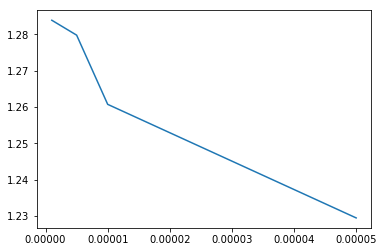

------------COMPLETED----------------


In [10]:
gradA = []
error =[]
for i in [0.000001,0.000005,0.00001,0.00005]:
    RMSE = test(10,30,0.005,i,i,0.5,0.001,1,20)
    error.append(RMSE)
    gradA.append(i)
plt.plot(gradA,error)
plt.show()
print("------------COMPLETED----------------")

------------NEW ITERATION-------------
For the following parameters:
F = 40
gradientLearningRateW = 3.435655467414276e-08
gradientLearningRateA = 8.589138668535691e-12
gradientLearningRateB = 8.589138668535691e-12
epochs = 30
momentum constant= 0.5
regularization constant = 0.001
batch size = 1
annealing constant = 20

----------------RESULTS-------------------


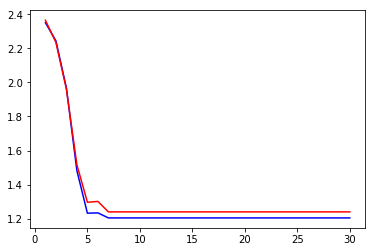

ideal VRMSE = 1.2396943596157715


1.2396943596157715

In [12]:
test(40,30,0.4,0.0001,0.0001,0.5,0.001,1,20)

------------NEW ITERATION-------------
For the following parameters:
F = 40
gradientLearningRateW = 0.3999999999981396
gradientLearningRateA = 0.0
gradientLearningRateB = 0.0
epochs = 30
momentum constant= 0
regularization constant = 0
batch size = 1
annealing constant = 99999999999999

----------------RESULTS-------------------


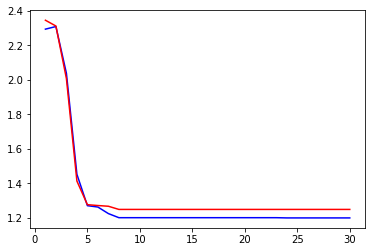

ideal VRMSE = 1.2489995996796794


1.2489995996796794

In [16]:
test(40,30,0.4,0,0,0,0,1,99999999999999)